In [1]:
import pandas as pd
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from torch import nn, optim
import time
from tempfile import TemporaryDirectory
import os

device = torch.device('cuda:0')

In [2]:
rows = pd.read_csv('content/outFrames/content.csv')
rows['class'] = rows['class'].fillna('None')

In [3]:
frames = { 'Train': [], 'Test': [] }
class_idxs =  { 'UD': 0, 'WF': 1, 'None': 2 } 
class_names = [ 'UD', 'WF', 'None' ]
main_ndarray = np.load('content/frame_array.npy')
main_ndarray = main_ndarray.astype('float32')

# BGR->RGB
main_ndarray = np.stack([
    main_ndarray[:, :, :, 2],
    main_ndarray[:, :, :, 1],
    main_ndarray[:, :, :, 0],
], axis=-1)
# (H,W,C) -> (C,W,H)
main_ndarray = main_ndarray.transpose((0, 3, 1, 2))
# Normalize
main_ndarray = (main_ndarray - 128.0) / 128.0 

grouped = rows.groupby(['video_name', 'interval', 'class', 'type'], as_index=False)
count = 0
skip = 16
target_size = 32
for grp, values in grouped:
    if len(values) < target_size:
        continue

    # TODO: Can get more sample if values is larger than target_size frame
    idxs = []
    for idx, row in values.iterrows():
        idxs.append(idx)

    i = 0
    while i+target_size <= len(idxs):
        frame_ndarray = main_ndarray[idxs[i:i+target_size],]
        i+=skip
        frames[grp[3]].append((frame_ndarray, class_idxs[grp[2]]))

In [4]:
dataloaders = {
    'Train': torch.utils.data.DataLoader(frames['Train'], batch_size=4, shuffle=True, num_workers=4),
    'Test': torch.utils.data.DataLoader(frames['Test'], batch_size=4, shuffle=True, num_workers=4),
}

dataset_sizes = {
    'Train': len(frames['Train']),
    'Test': len(frames['Test']), 
}

print(f'Size of training set {dataset_sizes["Train"]}')
print(f'Size of testing set {dataset_sizes["Test"]}')

Size of training set 189
Size of testing set 66


In [5]:
label_count = {}
for _, k in frames["Train"]:
    if class_names[k] not in label_count:
        label_count[class_names[k]] = 0
    label_count[class_names[k]] += 1

label_count

{'None': 66, 'UD': 57, 'WF': 66}

In [6]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


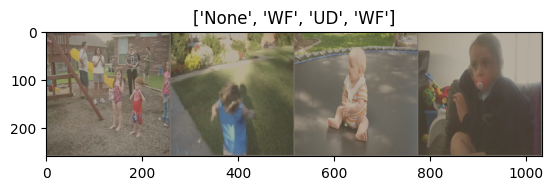

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

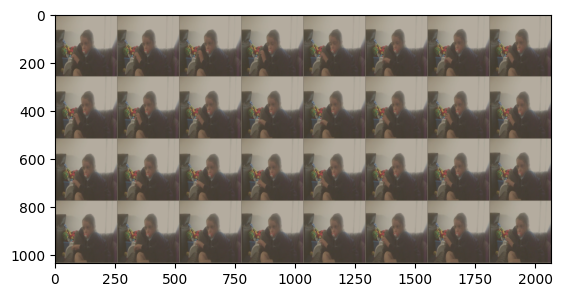

In [8]:
# Get a frame
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[0,:]

# Make a grid from frame
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [9]:
def train_model(model, criterion, optimizer, scheduler, transform=None, num_epochs=25):
    since = time.time()
    losses = {'Train': [], 'Test': []}
    accuracies = {'Train': [], 'Test': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = './best_model_params.pt'

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    if transform != None:
                        inputs = transform(inputs).to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                losses[phase].append(float(epoch_loss))
                accuracies[phase].append(float(epoch_acc))

                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            # Stop early on two consecutive higher test loss
            #if len(losses['Test']) > 2 and losses['Test'][-1] > losses['Test'][-2] and losses['Test'][-2] > losses['Test'][-3]:
             #   break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    _, axes = plt.subplots(2, 1)
    axes[0].plot(losses['Train'], label='Train loss')
    axes[0].plot(losses['Test'], label='Test loss')
    axes[0].legend()
    
    axes[1].plot(accuracies['Train'], label='Train accuracy')
    axes[1].plot(accuracies['Test'], label='Test accuracy')
    axes[1].legend()
    
    return model

In [10]:
import torch.nn.functional as F

class VideoModel(nn.Module):

    def __init__(self, num_classes, lstm_hidden_size=128, num_lstm_layers=1):
        super(VideoModel, self).__init__()

        # CNN blocks
        self.block1 = nn.Sequential(
            nn.Conv3d(3, 4, (2, 3, 3)),
            nn.BatchNorm3d(4),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Dropout(0.2)
        )
        self.block2 = nn.Sequential(
            nn.Conv3d(4, 16, (2, 3, 3)),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Dropout(0.2)
        )
        self.block3 = nn.Sequential(
            nn.Conv3d(16, 64, (2, 3, 3)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((1, 4, 4)),
            nn.Dropout(0.2)
        )
        self.block4 = nn.Sequential(
            nn.Conv3d(64, 256, (2, 3, 3)),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d((1, 4, 4)),
            nn.AdaptiveMaxPool3d((12, 1, 1)),
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=12,  # Assuming output size from the last CNN block
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # Change dimensions for 3D CNN
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Reshape for LSTM input
        batch_size, num_frames, channels, height, width = x.size()
        x = x.view(batch_size, num_frames, -1)

        # Apply LSTM
        lstm_output, _ = self.lstm(x)

        # Take the output from the last time step
        lstm_output = lstm_output[:, -1, :]

        # Classifier
        output = self.fc(lstm_output)

        return output



In [11]:
import torchvision.transforms.v2 as transforms

num_classes = 3
model_ft = VideoModel(num_classes=num_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.0000000)
#optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=5e-4, weight_decay=0.0000000)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

model_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_ft

VideoModel(
  (block1): Sequential(
    (0): Conv3d(3, 4, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Conv3d(4, 16, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (block3): Sequential(
    (0): Conv3d(16, 64, kernel_size=(2, 3, 3), stride=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 4, 4), stride=(1, 4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, 

Epoch 0/99
----------
Train Loss: 1.1140 Acc: 0.3069
Test Loss: 1.0786 Acc: 0.4848
Epoch 1/99
----------
Train Loss: 1.1005 Acc: 0.3016
Test Loss: 1.0882 Acc: 0.4848
Epoch 2/99
----------
Train Loss: 1.0978 Acc: 0.3333
Test Loss: 1.0867 Acc: 0.4848
Epoch 3/99
----------
Train Loss: 1.0977 Acc: 0.3651
Test Loss: 1.0923 Acc: 0.4697
Epoch 4/99
----------
Train Loss: 1.0847 Acc: 0.3439
Test Loss: 1.0793 Acc: 0.4848
Epoch 5/99
----------
Train Loss: 1.0740 Acc: 0.4127
Test Loss: 1.0950 Acc: 0.4545
Epoch 6/99
----------
Train Loss: 1.0611 Acc: 0.4021
Test Loss: 1.0961 Acc: 0.4242
Epoch 7/99
----------
Train Loss: 1.0706 Acc: 0.4021
Test Loss: 1.0941 Acc: 0.4545
Epoch 8/99
----------
Train Loss: 1.0411 Acc: 0.4339
Test Loss: 1.1022 Acc: 0.4394
Epoch 9/99
----------
Train Loss: 1.0323 Acc: 0.4339
Test Loss: 1.1274 Acc: 0.4394
Epoch 10/99
----------
Train Loss: 0.9951 Acc: 0.5026
Test Loss: 1.1286 Acc: 0.4545
Epoch 11/99
----------
Train Loss: 0.9982 Acc: 0.5079
Test Loss: 1.1319 Acc: 0.4545
Ep

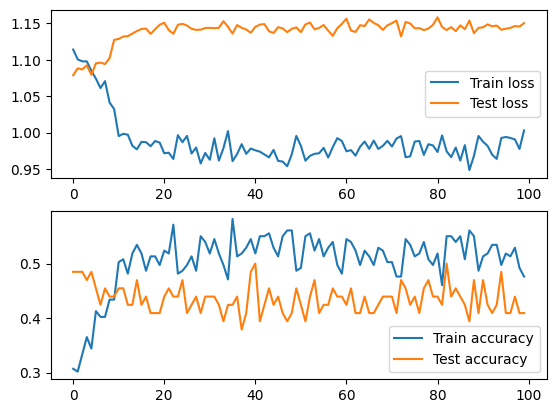

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, transform=model_transform,
                       num_epochs=100)

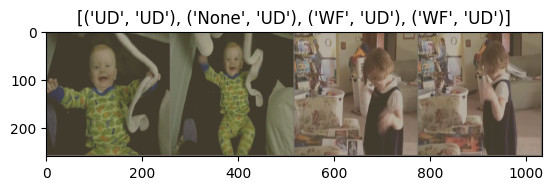

In [13]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Test']))

inferred_class = model_ft(inputs.to(device))

predicted_class = list(torch.argmax(inferred_class, dim=-1))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[(class_names[classes[x]], class_names[predicted_class[x]]) for x in range(len(classes))])

In [14]:
from sklearn.metrics import confusion_matrix

true_label = []
predicted_label = []
for input, label in dataloaders['Train']:
    true_label = true_label + label.tolist()
    pred = model_ft(model_transform(input).to(device))
    pred = pred.argmax(-1)
    predicted_label = predicted_label + pred.tolist()


In [15]:
confusion_matrix(true_label, predicted_label)

array([[ 8, 42,  7],
       [ 6, 59,  1],
       [16, 48,  2]])